In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [13]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import math
import random
import numpy  as np
import pandas as pd
#
from   functools           import partial
from   typing              import Tuple
from   fastcore.foundation import patch


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Torch library
#
import torch               as t
import torch.nn            as nn
import torch.nn.functional as F
from   torch               import optim
import pytorch_lightning   as pl



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Neural Forecast library
#
from neuralforecast.models.components.tcn    import _TemporalConvNet
from neuralforecast.models.components.common import Chomp1d, RepeatVector
from neuralforecast.losses.utils             import LossFunction
from neuralforecast.data.tsdataset           import WindowsDataset
from neuralforecast.data.tsloader            import TimeSeriesLoader

In [14]:
#export
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)
    
    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

In [15]:
#export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, interpolation_mode: str):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
 
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        if self.interpolation_mode=='nearest':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif self.interpolation_mode=='linear':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = len(backcast)
            knots = knots[:,None,None,:]
            forecast = t.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:]

        return backcast, forecast

In [16]:
#export
class _ExogenousBasisInterpretable(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis = insample_x_t
        forecast_basis = outsample_x_t

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisWavenet(nn.Module):
    def __init__(self, out_features, in_features, num_levels=4, kernel_size=3, dropout_prob=0):
        super().__init__()
        # Shape of (1, in_features, 1) to broadcast over b and t
        self.weight = nn.Parameter(t.Tensor(1, in_features, 1), requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(0.5))

        padding = (kernel_size - 1) * (2**0)
        input_layer = [nn.Conv1d(in_channels=in_features, out_channels=out_features,
                                 kernel_size=kernel_size, padding=padding, dilation=2**0),
                                 Chomp1d(padding),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_prob)]
        conv_layers = []
        for i in range(1, num_levels):
            dilation = 2**i
            padding = (kernel_size - 1) * dilation
            conv_layers.append(nn.Conv1d(in_channels=out_features, out_channels=out_features,
                                         padding=padding, kernel_size=3, dilation=dilation))
            conv_layers.append(Chomp1d(padding))
            conv_layers.append(nn.ReLU())
        conv_layers = input_layer + conv_layers

        self.wavenet = nn.Sequential(*conv_layers)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = x_t * self.weight # Element-wise multiplication, broadcasted on b and t. Weights used in L1 regularization
        x_t = self.wavenet(x_t)[:]

        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisTCN(nn.Module):
    def __init__(self, out_features, in_features, num_levels = 4, kernel_size=2, dropout_prob=0):
        super().__init__()
        n_channels = num_levels * [out_features]
        self.tcn = _TemporalConvNet(num_inputs=in_features, num_channels=n_channels, kernel_size=kernel_size, dropout=dropout_prob)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = self.tcn(x_t)[:]
        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

In [17]:
#export
def _init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

In [18]:
#export
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class _NHITSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_mlp_units: list,
                 n_pool_kernel_size: int, pooling_mode: str, basis: nn.Module,
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation: str):
        """
        """
        super().__init__()

        assert (pooling_mode in ['max','average'])

        n_time_in_pooled = int(np.ceil(n_time_in/n_pool_kernel_size))

        if n_s == 0:
            n_s_hidden = 0
        n_mlp_units = [n_time_in_pooled + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_mlp_units
        
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.n_pool_kernel_size = n_pool_kernel_size
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        if pooling_mode == 'max':
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)
        elif pooling_mode == 'average':
            self.pooling_layer = nn.AvgPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_mlp_units[i], out_features=n_mlp_units[i+1]))
            hidden_layers.append(activ)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_mlp_units[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_mlp_units[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)
        
        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

In [19]:
#export
class _NHITS(nn.Module):
    """
    NHITS Model.
    """
    def __init__(self, 
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 n_x_hidden,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_mlp_units: list,
                 n_pool_kernel_size: list,
                 n_freq_downsample: list,
                 pooling_mode,
                 interpolation_mode,
                 dropout_prob_theta,
                 activation,
                 initialization,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_x_hidden=n_x_hidden,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_mlp_units=n_mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   initialization=initialization)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, 
                     n_time_in, n_time_out, 
                     n_x, n_x_hidden, n_s, n_s_hidden, 
                     n_layers, n_mlp_units, 
                     n_pool_kernel_size, n_freq_downsample, pooling_mode, interpolation_mode,
                     batch_normalization, dropout_prob_theta, 
                     activation, shared_weights, initialization):                     
        block_list = []
        for i in range(len(stack_types)):
            assert stack_types[i] in ['identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'], 'f Invalid stack type {stack_types[i]}'
            for block_id in range(n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'identity':
                        n_theta = (n_time_in + max(n_time_out//n_freq_downsample[i], 1) )
                        basis = _IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out,
                                              interpolation_mode=interpolation_mode)                        

                    elif stack_types[i] == 'exogenous':
                        n_theta = 2 * n_x
                        basis = _ExogenousBasisInterpretable()

                    elif stack_types[i] == 'exogenous_tcn':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisTCN(n_x_hidden, n_x)

                    elif stack_types[i] == 'exogenous_wavenet':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisWavenet(n_x_hidden, n_x)

                    nbeats_block = _NHITSBlock(n_time_in=n_time_in,
                                               n_time_out=n_time_out,
                                               n_x=n_x,
                                               n_s=n_s,
                                               n_s_hidden=n_s_hidden,
                                               n_theta=n_theta,
                                               n_mlp_units=n_mlp_units[i],
                                               n_pool_kernel_size=n_pool_kernel_size[i],
                                               pooling_mode=pooling_mode,
                                               basis=basis,
                                               n_layers=n_layers[i],
                                               batch_normalization=batch_normalization_block,
                                               dropout_prob=dropout_prob_theta,
                                               activation=activation)

                # Select type of evaluation and apply it to all layers of block
                init_function = partial(_init_weights, initialization=initialization)                                             
                nbeats_block.layers.apply(init_function)
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                insample_mask: t.Tensor, outsample_mask: t.Tensor,
                return_decomposition: bool=False):
        
        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]
        insample_mask = insample_mask[:, :-self.n_time_out]
        
        # outsample
        outsample_y   = Y[:, -self.n_time_out:]
        outsample_x_t = X[:, :, -self.n_time_out:]
        outsample_mask = outsample_mask[:, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y, 
                                                                    insample_x_t=insample_x_t, 
                                                                    insample_mask=insample_mask,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts, outsample_mask
        
        else:
            forecast = self.forecast(insample_y=insample_y,
                                     insample_x_t=insample_x_t, 
                                     insample_mask=insample_mask,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast, outsample_mask

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))
        
        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)
        
        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]
                
        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)
            
        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

# N-HiTS

A new model for long-horizon forecasting which incorporates novel hierarchical interpolation and multi-rate data sampling techniques to specialize blocks of its architecture to different frequency band of the time-series signal. It achieves SoTA performance on several benchmark datasets, outperforming current Transformer-based models by more than 25%. Paper available at https://arxiv.org/abs/2201.12886

In [20]:
#export
class NHITS(pl.LightningModule):
    def __init__(self,
                 n_time_in,
                 n_time_out,
                 n_x,
                 n_s,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_mlp_units,
                 n_x_hidden,
                 n_s_hidden,
                 n_pool_kernel_size,
                 n_freq_downsample,
                 pooling_mode,
                 interpolation_mode,
                 batch_normalization,
                 dropout_prob_theta,
                 learning_rate,
                 lr_decay,
                 lr_decay_step_size,
                 weight_decay,
                 loss_train,
                 loss_hypar,
                 loss_valid,
                 frequency,
                 random_seed):
        """
        N-HiTS model.

            Parameters
            ----------
            n_time_in: int
                Multiplier to get insample size.
                Insample size = n_time_in * output_size
            n_time_out: int
                Forecast horizon.
            n_x: int
                Number of exogenous variables.
            n_s: int
                Number of static variables.
            shared_weights: bool
                If True, all blocks within each stack will share parameters.
            activation: str
                Activation function.
                An item from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].
            initialization: str
                Initialization function.
                An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
            stack_types: List[str]
                List of stack types.
                Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
            n_blocks: List[int]
                Number of blocks for each stack.
                Note that len(n_blocks) = len(stack_types).
            n_layers: List[int]
                Number of layers for each stack type.
                Note that len(n_layers) = len(stack_types).
            n_mlp_units: List[List[int]]
                Structure of hidden layers for each stack type.
                Each internal list should contain the number of units of each hidden layer.
                Note that len(n_hidden) = len(stack_types).
            n_x_hidden: int
                Number of hidden output channels of exogenous_tcn and exogenous_wavenet stacks. 
            n_s_hidden: int
                Number of encoded static features, output dim of _StaticFeaturesEncoder. 
            n_pool_kernel_size List[int]:
                Pooling size for input for each stack.
                Note that len(n_pool_kernel_size) = len(stack_types).
            n_freq_downsample List[int]:
                Downsample multiplier of output for each stack. Expressivity ratio (r) = 1/n_freq_downsample
                Note that len(n_freq_downsample) = len(stack_types).
            pooling_mode: str
                Pooling type.
                An item from ['average', 'max']
            interpolation_mode: str
                Interpolation function.
                An item from ['linear', 'nearest', 'cubic']
            batch_normalization: bool
                Whether perform batch normalization.
            dropout_prob_theta: float
                Float between (0, 1).
                Dropout for Nbeats basis.
            learning_rate: float
                Learning rate between (0, 1).
            lr_decay: float
                Decreasing multiplier for the learning rate.
            lr_decay_step_size: int
                Steps between each learning rate decay.
            weight_decay: float
                L2 penalty for optimizer.
            loss_train: str
                Loss to optimize.
                An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
            loss_hypar:
                Hyperparameter for chosen loss.
            loss_valid:
                Validation loss.
                An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
            frequency: str
                Time series frequency.
            random_seed: int
                random_seed for pseudo random pytorch initializer and
                numpy random generator.
        """
        
        super(NHITS, self).__init__()

        if activation == 'SELU': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_x = n_x
        self.n_x_hidden = n_x_hidden
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_mlp_units = n_mlp_units
        self.n_pool_kernel_size = n_pool_kernel_size
        self.n_freq_downsample = n_freq_downsample
        self.pooling_mode = pooling_mode
        self.interpolation_mode = interpolation_mode

        # Loss functions
        self.loss_train = loss_train
        self.loss_hypar = loss_hypar
        self.loss_valid = loss_valid
        self.loss_fn_train = LossFunction(loss_train,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        self.loss_fn_valid = LossFunction(loss_valid,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        
        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta        
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.lr_decay_step_size = lr_decay_step_size
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.return_decomposition = False

        self.model = _NHITS(n_time_in=self.n_time_in,
                            n_time_out=self.n_time_out,
                            n_s=self.n_s,
                            n_x=self.n_x,
                            n_s_hidden=self.n_s_hidden,
                            n_x_hidden=self.n_x_hidden,
                            stack_types=self.stack_types,
                            n_blocks=self.n_blocks,
                            n_layers=self.n_layers,
                            n_mlp_units=self.n_mlp_units,
                            n_pool_kernel_size=self.n_pool_kernel_size,
                            n_freq_downsample=self.n_freq_downsample,
                            pooling_mode=self.pooling_mode,
                            interpolation_mode=self.interpolation_mode,
                            dropout_prob_theta=self.dropout_prob_theta,
                            activation=self.activation,
                            initialization=self.initialization,
                            batch_normalization=self.batch_normalization,
                            shared_weights=self.shared_weights)

    def training_step(self, batch, batch_idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_train(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask = available_mask,
                                                           outsample_mask = sample_mask,
                                                           return_decomposition = False)

        loss = self.loss_fn_valid(y          = outsample_y,
                                  y_hat      = forecast,
                                  mask       = outsample_mask,
                                  y_insample = Y)

        self.log('val_loss', loss, prog_bar = True)
        
        return loss

    def on_fit_start(self):
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

    def forward(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        if self.return_decomposition:
            outsample_y, forecast, block_forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                                     insample_mask=available_mask,
                                                                     outsample_mask=sample_mask,
                                                                     return_decomposition=True)
            return outsample_y, forecast, block_forecast, outsample_mask

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)
        return outsample_y, forecast, outsample_mask

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.learning_rate, 
                               weight_decay=self.weight_decay)
        
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                 step_size=self.lr_decay_step_size, 
                                                 gamma=self.lr_decay)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
     

# N-HITS Usage Example

# Parameters

In [21]:
Lag = 3*6

Horizon = 6 # Horizon = 24 -> 2 hours

## Data handling parameters

In [22]:
# Parameters
#
filename   = 'metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

## Import data


In [30]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.14 seconds


,Date,PM2.5,PM10,NO2,CO
0,2022-01-27 16:12:40,0.5,0.5,75.0,298.0
1,2022-01-27 16:12:56,0.5,0.5,75.0,298.0
2,2022-01-27 16:13:13,0.5,0.5,76.0,298.0


In [31]:
for feature in df.columns:
    try:
        df[feature] = np.log( df[feature] + 1.0 )
    except:
        print(feature)

Date


## Pre-process

In [33]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')


# Set index
#
df.set_index('Date', inplace=True)


# Resampling
#
df = df.resample('5min').mean().interpolate().reset_index()

# Keep PM2.5' & 'PM10'
#
df = df[ ['Date', 'PM2.5', 'PM10'] ]

In [34]:
df = df.rename(columns = {'Date': 'ds'})

In [35]:
df.head( 5 )

,ds,PM2.5,PM10
0,2022-01-27 16:10:00,0.389070,0.389070
1,2022-01-27 16:15:00,0.379812,0.390237
2,2022-01-27 16:20:00,0.534958,0.679558
3,2022-01-27 16:25:00,0.498939,0.575386
4,2022-01-27 16:30:00,0.591520,0.651396


### Load Data

In [36]:
def createDataframes( df ):
    S_df = pd.DataFrame({'unique_id':['PM2.5', 'PM10'], 'static_PM2.5':[1, 0], 'static_PM10':[0,1]})
    
    Y_df = None
    for feature in ['PM2.5', 'PM10']:
        if (Y_df is None):
            Y_df = pd.DataFrame({'ds': df['ds'], 'y': df[feature]})
            Y_df['unique_id'] = feature
        else:
            temp_df = pd.DataFrame({'ds': df['ds'], 'y': df[feature]})
            temp_df['unique_id'] = feature        

            Y_df = pd.concat([Y_df, temp_df], ignore_index=True)

    Y_df = Y_df[ ['unique_id', 'ds', 'y'] ]
    
    
    
    X_df = None
    for feature in ['PM2.5', 'PM10']:
        if (X_df is None):
            X_df = df.copy()
            X_df['unique_id'] = feature
        else:
            temp_df = df.copy()
            temp_df['unique_id'] = feature

            X_df = pd.concat([X_df, temp_df], ignore_index = True)

    X_df = X_df[ ['unique_id', 'ds', 'Temperature', 'Humidity', 'PM2.5', 'PM10'] ]
    
    return (X_df, Y_df, S_df)

## Create data

In [37]:
X_df, Y_df, S_df = createDataframes( df )

KeyError: "['Temperature', 'Humidity'] not in index"

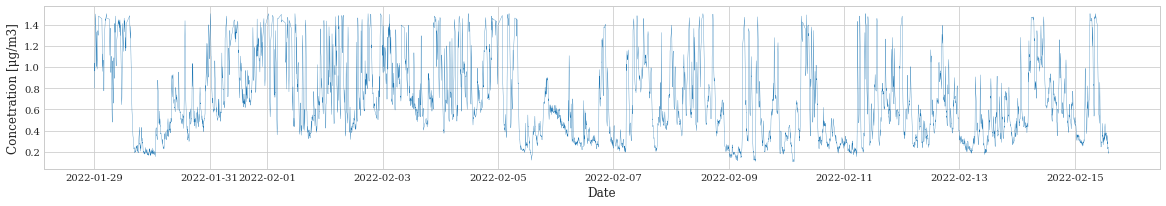

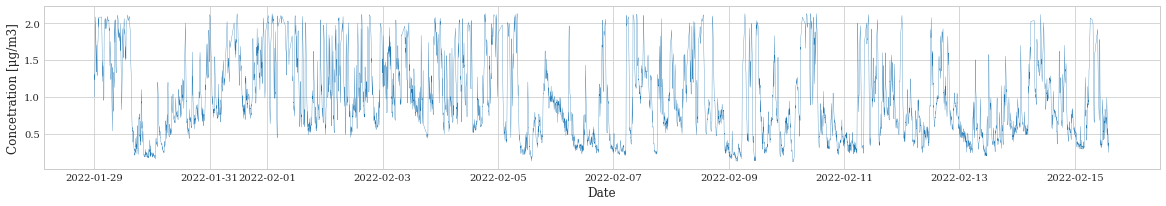

In [19]:
import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'




for feature in ['PM2.5', 'PM10']:
    fig = plt.figure(figsize=(20, 3))
    
    plt.plot(Y_df[Y_df['unique_id']==feature].ds, Y_df[Y_df['unique_id']==feature].y.values, linewidth=0.3)
    plt.ylabel('Concetration [μg/m3]', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.show()


### Declare Model and Data Parameters

In [20]:
# Architecture parameters
mc = {}
mc['model'] = 'n-hits'
mc['mode'] = 'simple'
mc['activation'] = 'SELU'

mc['n_time_in']  = Lag
mc['n_time_out'] = Horizon
mc['n_x_hidden'] = 4
mc['n_s_hidden'] = 0

mc['stack_types'] = ['identity', 'identity', 'identity']
mc['n_blocks'] = 1
mc['n_layers'] = 2
mc['n_mlp_units'] = 256
mc['n_pool_kernel_size'] = [4, 2, 1]
mc['n_freq_downsample']  = [24, 12, 1]
mc['pooling_mode'] = 'max'
mc['interpolation_mode'] = 'linear'
mc['shared_weights'] = False

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.001
mc['batch_size'] = 1
mc['n_windows'] = 32
mc['lr_decay'] = 0.5
mc['lr_decay_step_size'] = 2
mc['max_epochs'] = 1000
mc['max_steps'] = None
mc['early_stop_patience'] = 20
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0.0
mc['dropout_prob_exogenous'] = 0.0
mc['weight_decay'] = 0
mc['loss_train'] = 'MSE'
mc['loss_hypar'] = 0.5
mc['loss_valid'] = mc['loss_train']
mc['random_seed'] = 1

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['normalizer_y'] = None
mc['normalizer_x'] = None#'median'
mc['complete_windows'] = False
mc['frequency'] = '5Min'

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_mlp_units'] = len(mc['stack_types']) * [ mc['n_layers'] * [int(mc['n_mlp_units'])] ]
mc['n_blocks']    = len(mc['stack_types']) * [ mc['n_blocks'] ]
mc['n_layers']    = len(mc['stack_types']) * [ mc['n_layers'] ]

model                                             n-hits
mode                                              simple
activation                                          SELU
n_time_in                                             72
n_time_out                                            24
n_x_hidden                                             4
n_s_hidden                                             0
stack_types               [identity, identity, identity]
n_blocks                                               1
n_layers                                               2
n_mlp_units                                          256
n_pool_kernel_size                             [4, 2, 1]
n_freq_downsample                            [24, 12, 1]
pooling_mode                                         max
interpolation_mode                                linear
shared_weights                                     False
initialization                              lecun_normal
learning_rate                  

### Instantiate Loaders and Model

In [21]:
from neuralforecast.experiments.utils import create_datasets

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc         = mc,
                                                                     S_df       = S_df, Y_df=Y_df, X_df=X_df,
                                                                     f_cols     = [],
                                                                     ds_in_val  =  500,
                                                                     ds_in_test =  500)

train_loader = TimeSeriesLoader(dataset    = train_dataset,
                                batch_size = int(mc['batch_size']),
                                n_windows  = mc['n_windows'],
                                shuffle    = True)

val_loader = TimeSeriesLoader(dataset      = val_dataset,
                              batch_size   = int(mc['batch_size']),
                              shuffle      = False)

test_loader = TimeSeriesLoader(dataset    = test_dataset,
                               batch_size = int(mc['batch_size']),
                               shuffle    = False)

mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

INFO:root:Train Validation splits

INFO:root:                                       ds                    
                                      min                 max
unique_id sample_mask                                        
PM10      0           2022-02-12 02:55:00 2022-02-15 14:10:00
          1           2022-01-29 00:00:00 2022-02-12 02:50:00
PM2.5     0           2022-02-12 02:55:00 2022-02-15 14:10:00
          1           2022-01-29 00:00:00 2022-02-12 02:50:00
INFO:root:
Total data 			10134 time stamps 
Available percentage=100.0, 	10134 time stamps 
Insample  percentage=80.26, 	8134 time stamps 
Outsample percentage=19.74, 	2000 time stamps 

/Users/livieris/PycharmProjects/DigIt/Air Quality/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)
INFO:root:Train Validation splits

INFO:root:                       

In [22]:
model = NHITS(n_time_in=int(mc['n_time_in']),
              n_time_out=int(mc['n_time_out']),
              n_x=mc['n_x'],
              n_s=mc['n_s'],
              n_s_hidden=int(mc['n_s_hidden']),
              n_x_hidden=int(mc['n_x_hidden']),
              shared_weights=mc['shared_weights'],
              initialization=mc['initialization'],
              activation=mc['activation'],
              stack_types=mc['stack_types'],
              n_blocks=mc['n_blocks'],
              n_layers=mc['n_layers'],
              n_mlp_units=mc['n_mlp_units'],
              n_pool_kernel_size=mc['n_pool_kernel_size'],
              n_freq_downsample=mc['n_freq_downsample'],
              pooling_mode=mc['pooling_mode'],
              interpolation_mode=mc['interpolation_mode'],
              batch_normalization = mc['batch_normalization'],
              dropout_prob_theta=mc['dropout_prob_theta'],
              learning_rate=float(mc['learning_rate']),
              lr_decay=float(mc['lr_decay']),
              lr_decay_step_size=float(mc['lr_decay_step_size']),
              weight_decay=mc['weight_decay'],
              loss_train=mc['loss_train'],
              loss_hypar=float(mc['loss_hypar']),
              loss_valid=mc['loss_valid'],
              frequency=mc['frequency'],
              random_seed=int(mc['random_seed']))

### Train Model

In [23]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=mc['early_stop_patience'],
                               verbose=False,
                               mode="min")

trainer = pl.Trainer(max_epochs        = mc['max_epochs'], 
                     max_steps         = mc['max_steps'],
                     gradient_clip_val = 1.0,
                     log_every_n_steps = 500, 
                     #
                     check_val_every_n_epoch   = 1,
                     callbacks                 = [early_stopping],
                     progress_bar_refresh_rate = None)


trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | model | _NHITS | 587 K 
---------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Total params
2.351     Total estimated model params size (MB)


/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers whic

Epoch 0:  50%|█████     | 2/4 [00:00<00:00, 50.22it/s, loss=38.2, v_num=2944, val_loss=1.310, train_loss_step=1.240]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 2/4 [00:00<00:00, 52.43it/s, loss=30.8, v_num=2944, val_loss=41.60, train_loss_step=42.00, train_loss_epoch=38.20]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 2/4 [00:00<00:00, 50.08it/s, loss=25.8, v_num=2944, val_loss=12.40, train_loss_step=13.90, train_loss_epoch=23.40]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 2/4 [00:00<00:00, 50.45it/s, loss=21.7, v_num=2944, val_loss=10.40, train_loss_step=13.40, train_loss_epoch=15.80]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 2/4 [00:00<00:00, 54.66it/s, loss=17.6, v_num=2944, val_loss=1.260, train_loss_step=1.540, train_loss_epoch=9.360]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 2/4 [00:00<00:00, 49.54it/s, loss=14.9, v_num=2944, val_loss=1.430, train_loss_step=1.340, train_loss_epoch=1.410]
Validating: 0it [00:00,

### Make Predictions

In [24]:
from sklearn.metrics             import mean_squared_error


# Process forecast and include in forecast_df
model.return_decomposition = False


outputs = trainer.predict(model, train_loader)
Real, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
print('Train MSE: ', mean_squared_error(Real, forecast))

outputs = trainer.predict(model, val_loader)
Real, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
print('Valid MSE: ', mean_squared_error(Real, forecast))

outputs = trainer.predict(model, test_loader)
Real, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
print('Test MSE: ', mean_squared_error(Real, forecast))

/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your predict_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)
/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 100%|██████████| 2/2 [00:00<?, ?it/s]

/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Train MSE:  0.24297084
Predicting: 100%|██████████| 2/2 [00:00<?, ?it/s]
Valid MSE:  0.115498714


/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 100%|██████████| 2/2 [00:00<?, ?it/s]
Test MSE:  0.17538647


/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Forecast

In [25]:
# Forecast
outputs = trainer.predict(model, test_loader)

/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 100%|██████████| 2/2 [00:00<?, ?it/s]


/Users/livieris/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [26]:
Real        = dict()
Predictions = dict()
for i, feature in enumerate( ['PM2.5', 'PM10'] ):
    Real[ feature ]        = outputs[i][0].cpu().numpy()
    Predictions[ feature ] = outputs[i][1].cpu().numpy()

In [27]:
from utils.PerformanceMetrics import RegressionEvaluation


feature = 'PM10'

print('[INFO] Feature: ', feature)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = np.exp( Real[ feature ][:,  i] )
    Prices['Prediction'] = np.exp( Predictions[ feature ][:,  i] )

            
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()

    # Present results
    #    
#     # Plot Real & Predicted values
#     #
#     Prices[:100].plot( figsize = (20, 3), marker = 'o' )
#     #
#     plt.title('Feature: {} - Horizon = {}'.format(feature, i+1))
#     plt.legend( frameon = False, fontsize = 14)
#     plt.xticks(size = 12)
#     plt.yticks(size = 12)
#     plt.show()  
    print('Horizon: %2i MAE: %5.2f SMAPE: %5.2f' %(i+1, MAE, SMAPE) )

[INFO] Feature:  PM10
------------------------------------------------
Horizon:  1 MAE:  0.19 SMAPE:  7.73
Horizon:  2 MAE:  0.31 SMAPE: 13.80
Horizon:  3 MAE:  0.36 SMAPE: 16.06
Horizon:  4 MAE:  0.36 SMAPE: 15.63
Horizon:  5 MAE:  0.40 SMAPE: 17.09
Horizon:  6 MAE:  0.47 SMAPE: 19.94
Horizon:  7 MAE:  0.50 SMAPE: 20.52
Horizon:  8 MAE:  0.54 SMAPE: 22.22
Horizon:  9 MAE:  0.60 SMAPE: 24.73
Horizon: 10 MAE:  0.58 SMAPE: 23.73
Horizon: 11 MAE:  0.59 SMAPE: 24.46
Horizon: 12 MAE:  0.61 SMAPE: 25.21
Horizon: 13 MAE:  0.62 SMAPE: 25.86
Horizon: 14 MAE:  0.65 SMAPE: 25.96
Horizon: 15 MAE:  0.68 SMAPE: 26.47
Horizon: 16 MAE:  0.70 SMAPE: 27.59
Horizon: 17 MAE:  0.74 SMAPE: 29.25
Horizon: 18 MAE:  0.75 SMAPE: 30.78
Horizon: 19 MAE:  0.77 SMAPE: 32.17
Horizon: 20 MAE:  0.72 SMAPE: 29.43
Horizon: 21 MAE:  0.70 SMAPE: 29.09
Horizon: 22 MAE:  0.69 SMAPE: 28.91
Horizon: 23 MAE:  0.71 SMAPE: 29.82
Horizon: 24 MAE:  0.71 SMAPE: 30.08


In [28]:
from utils.PerformanceMetrics import RegressionEvaluation


feature = 'PM2.5'

print('[INFO] Feature: ', feature)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = np.exp( Real[ feature ][:,  i] )
    Prices['Prediction'] = np.exp( Predictions[ feature ][:,  i] )

            
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )


    # Present results
    #
    print('Horizon: %2i MAE: %5.2f SMAPE: %5.2f' %(i+1, MAE, SMAPE) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE:  0.37 SMAPE: 11.32
Horizon:  2 MAE:  0.60 SMAPE: 18.23
Horizon:  3 MAE:  0.70 SMAPE: 22.41
Horizon:  4 MAE:  0.74 SMAPE: 22.46
Horizon:  5 MAE:  0.85 SMAPE: 25.11
Horizon:  6 MAE:  0.93 SMAPE: 27.71
Horizon:  7 MAE:  0.98 SMAPE: 28.54
Horizon:  8 MAE:  1.05 SMAPE: 30.30
Horizon:  9 MAE:  1.14 SMAPE: 33.00
Horizon: 10 MAE:  1.10 SMAPE: 32.13
Horizon: 11 MAE:  1.12 SMAPE: 32.71
Horizon: 12 MAE:  1.17 SMAPE: 33.36
Horizon: 13 MAE:  1.16 SMAPE: 33.67
Horizon: 14 MAE:  1.24 SMAPE: 34.49
Horizon: 15 MAE:  1.33 SMAPE: 35.98
Horizon: 16 MAE:  1.40 SMAPE: 37.69
Horizon: 17 MAE:  1.49 SMAPE: 39.68
Horizon: 18 MAE:  1.44 SMAPE: 40.46
Horizon: 19 MAE:  1.47 SMAPE: 41.98
Horizon: 20 MAE:  1.42 SMAPE: 40.19
Horizon: 21 MAE:  1.42 SMAPE: 40.72
Horizon: 22 MAE:  1.43 SMAPE: 41.21
Horizon: 23 MAE:  1.49 SMAPE: 42.88
Horizon: 24 MAE:  1.48 SMAPE: 43.58


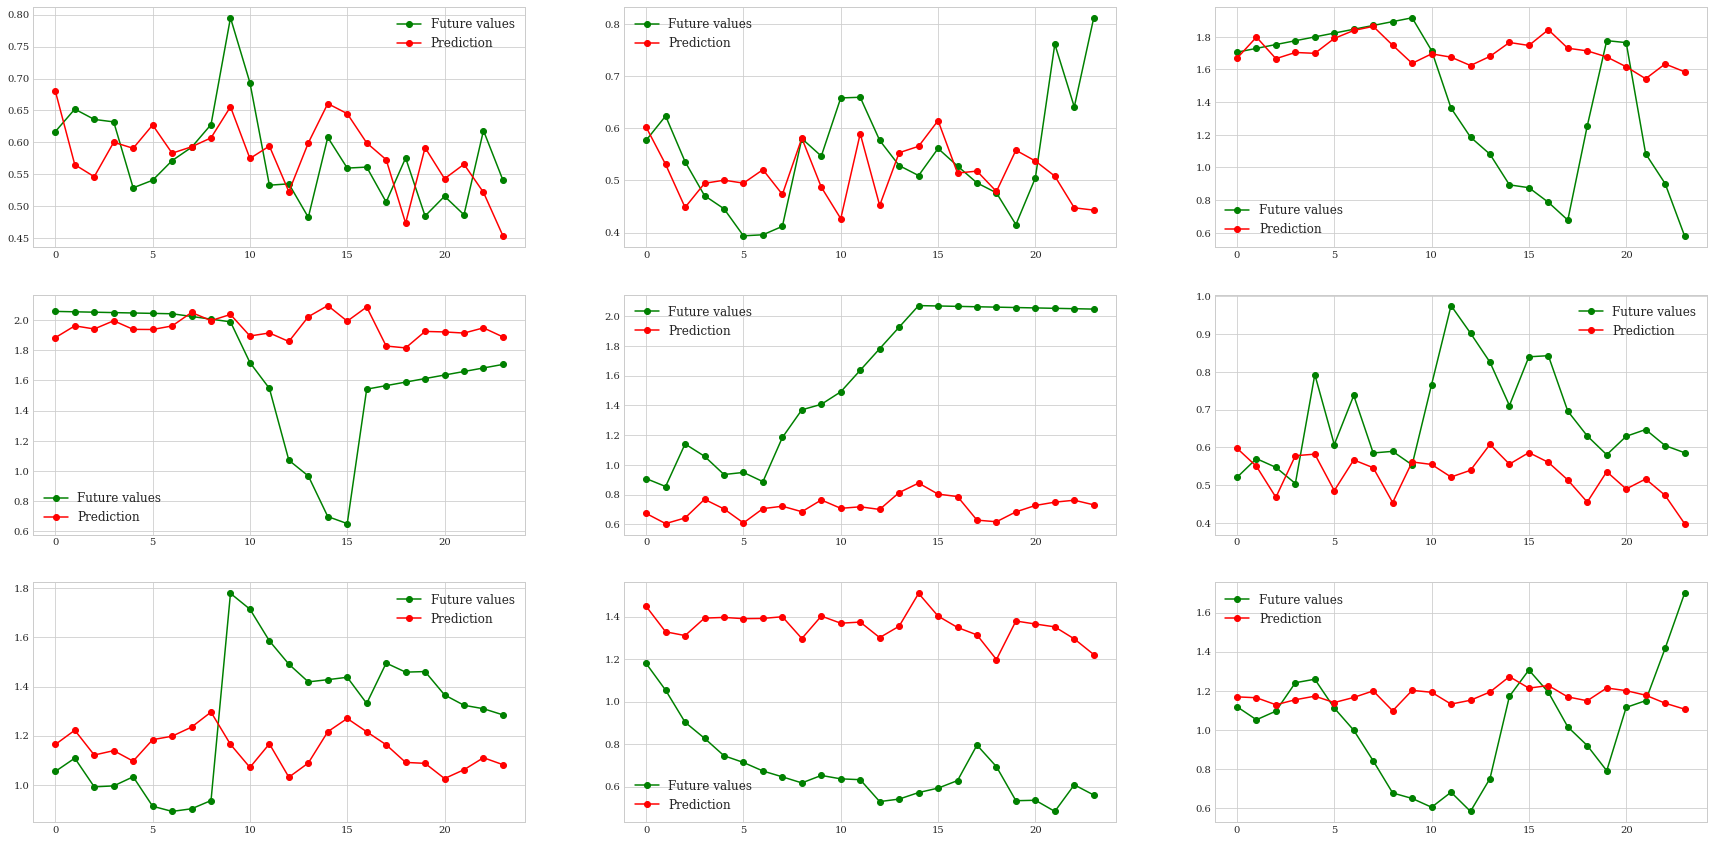

In [29]:
import matplotlib.pyplot as plt

subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 15) )
RandomInstances = [random.randint(1, Real['PM2.5'].shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(range(Horizon), Real['PM2.5'][i],        color='g', marker = 'o')
    plt.plot(range(Horizon), Predictions['PM2.5'][i], color='r', marker = 'o')

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

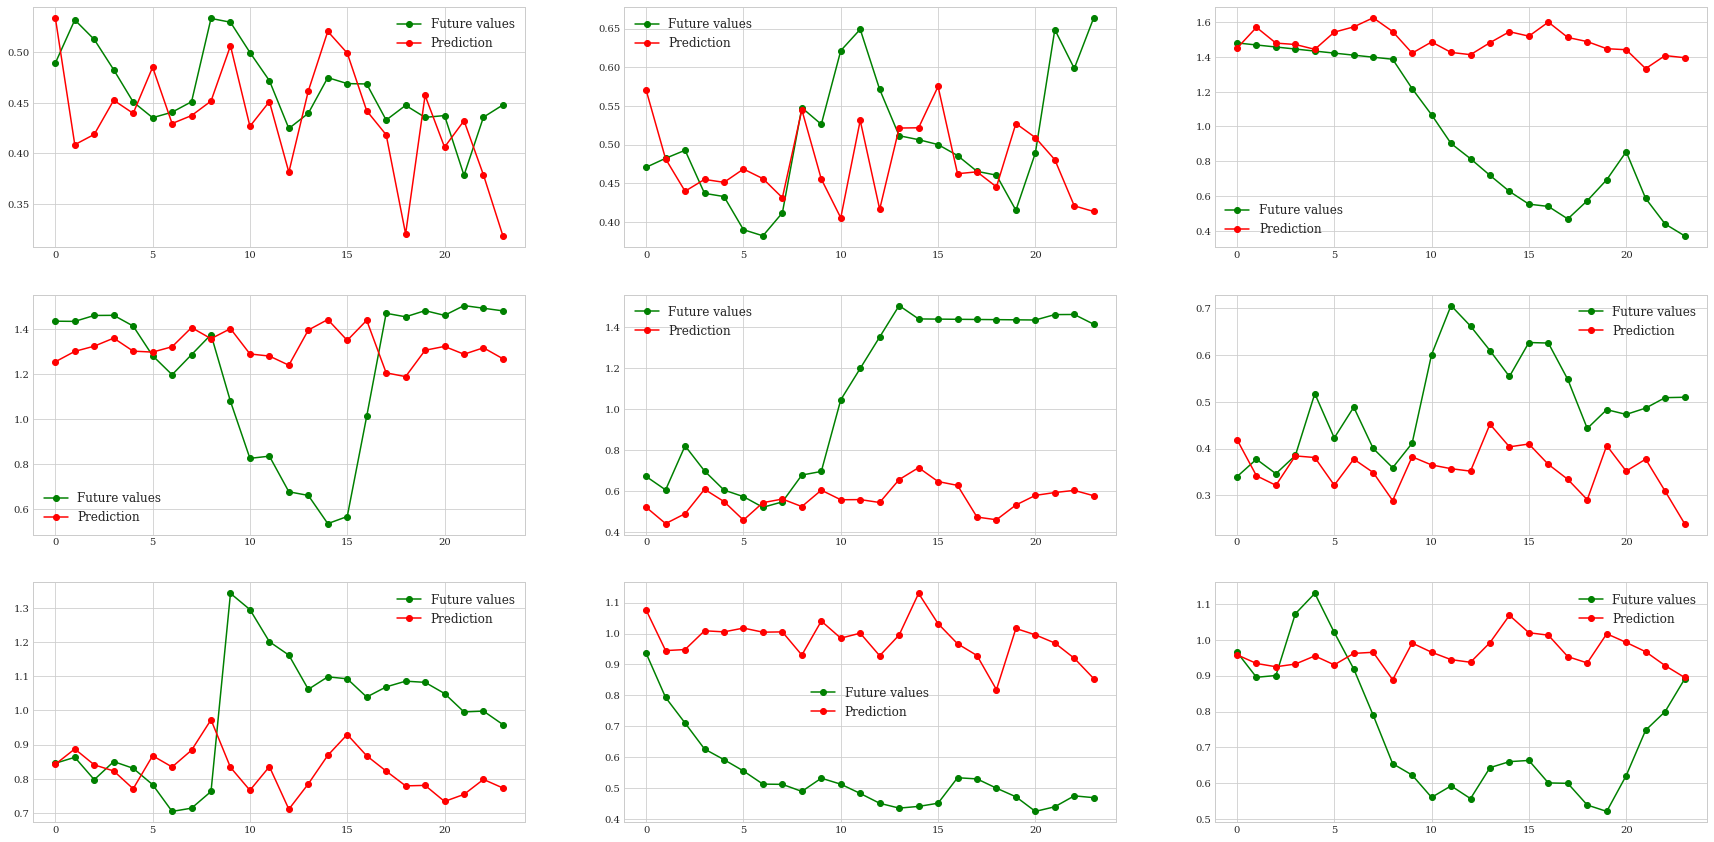

In [30]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 15) )

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(range(Horizon), Real['PM10'][i],        color='g', marker = 'o')
    plt.plot(range(Horizon), Predictions['PM10'][i], color='r', marker = 'o')

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

In [31]:
#export
@patch
def forecast(self: NHITS, Y_df, X_df = None, S_df = None, batch_size=1):
    """
    Method for forecasting self.n_time_out periods after last timestamp of Y_df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    bath_size: int
        Batch size for forecasting.

    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """

    # Dataset, loader and trainer
    dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                mask_df     = None, 
                                f_cols      = [],
                                input_size  = self.n_time_in,
                                output_size = self.n_time_out,
                                sample_freq = 1,
                                complete_windows = True,
                                ds_in_test       = self.n_time_out,
                                is_test          = True,
                                verbose          = False)

    loader = TimeSeriesLoader(dataset    = dataset,
                              batch_size = batch_size,
                              shuffle    = False)

    trainer = pl.Trainer()

    # Forecast
    outputs = trainer.predict(self, loader)

    # Process forecast and include in forecast_df
    _, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
#     forecast_df['y'] = forecast.flatten()

    return forecast





In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
# X_df, Y_df, S_df = createDataframes( df )

In [34]:
Date = '2022-02-13 20:35:00'

In [35]:
REAL        = []
PREDICTIONS = []
for i, date in enumerate( pd.date_range(start = Date, end = Y_df['ds'].max(), freq=mc['frequency'])[:-24] ):
    if (i % Horizon != 0): continue
    
    Y_forecast_df = Y_df[Y_df['ds'] < date]
    X_forecast_df = X_df[X_df['ds'] < date]
    
#     print(forecast_dates)
    
    # Add forecast dates to Y_df
    Y_forecast_df['ds'] = pd.to_datetime(Y_forecast_df['ds'])

    forecast_dates = pd.date_range(Y_forecast_df['ds'].max(), periods=mc['n_time_out']+1, freq=mc['frequency'])[1:]


    model.return_decomposition = False    
    forecasts = model.forecast(Y_df = Y_forecast_df, X_df = X_forecast_df, S_df = S_df)
    

    
    forecast_df = pd.DataFrame({'ds':forecast_dates, 'PM10':forecasts[0], 'PM2.5':forecasts[1]})    
    
    
    
#     Y_df[(Y_df['ds'] <= forecast_dates.astype('str')[-1]) & (Y_df['unique_id'] == 'PM10')].set_index('ds')[-24:]['y'].plot( marker = 'o' )
#     forecast_df.set_index('ds')[ 'PM10' ].plot( marker = 'o' )
#     plt.show()
    
#     Y_df[(Y_df['ds'] <= forecast_dates.astype('str')[-1]) & (Y_df['unique_id'] == 'PM2.5')].set_index('ds')[-24:]['y'].plot( marker = 'o' )
#     forecast_df.set_index('ds')[ 'PM2.5' ].plot( marker = 'o' )
#     plt.show()    
    
    
    REAL += [ Y_df[(Y_df['ds'] <= forecast_dates.astype('str')[-1]) & (Y_df['unique_id'] == 'PM2.5')].set_index('ds')[-24:]['y'].to_numpy()]
    PREDICTIONS += [ forecast_df[ 'PM2.5' ].to_numpy() ]
#     REAL += [ Y_df[(Y_df['ds'] <= forecast_dates.astype('str')[-1]) & (Y_df['unique_id'] == 'PM10')].set_index('ds')[-24:]['y'].to_numpy()]
#     PREDICTIONS += [ forecast_df[ 'PM10' ].to_numpy() ]

    
#     break

#     plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 301.48it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting: 100%|██████████| 2/2 [00:00<00:00, 328.36it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 380.02it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 388.20it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting: 100%|██████████| 2/2 [00:00<00:00, 420.27it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 436.95it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting: 100%|██████████| 2/2 [00:00<00:00, 477.77it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 381.46it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 437.64it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 460.84it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 455.70it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 457.97it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 396.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 308.05it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 503.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 348.68it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 326.53it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 421.92it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 439.56it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 100%|██████████| 2/2 [00:00<00:00, 494.93it/s]


In [36]:
REAL        = np.array(REAL)
PREDICTIONS = np.array(PREDICTIONS)

In [37]:
from utils.PerformanceMetrics import RegressionEvaluation


# feature = 'PM10'

# print('[INFO] Feature: ', feature)
# print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = np.exp( REAL[:,  i] )
    Prices['Prediction'] = np.exp( PREDICTIONS[:,  i] )

            
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )


    # Present results
    #
    print('Horizon: %2i MAE: %5.2f SMAPE: %5.2f' %(i+1, MAE, SMAPE) )


Horizon:  1 MAE:  0.77 SMAPE: 31.57
Horizon:  2 MAE:  0.85 SMAPE: 34.92
Horizon:  3 MAE:  0.74 SMAPE: 31.08
Horizon:  4 MAE:  0.72 SMAPE: 28.83
Horizon:  5 MAE:  0.76 SMAPE: 30.33
Horizon:  6 MAE:  0.78 SMAPE: 30.73
Horizon:  7 MAE:  0.73 SMAPE: 28.99
Horizon:  8 MAE:  0.71 SMAPE: 28.42
Horizon:  9 MAE:  0.69 SMAPE: 29.40
Horizon: 10 MAE:  0.60 SMAPE: 26.71
Horizon: 11 MAE:  0.67 SMAPE: 29.65
Horizon: 12 MAE:  0.82 SMAPE: 33.97
Horizon: 13 MAE:  0.74 SMAPE: 31.74
Horizon: 14 MAE:  0.74 SMAPE: 30.80
Horizon: 15 MAE:  0.83 SMAPE: 33.15
Horizon: 16 MAE:  0.79 SMAPE: 31.69
Horizon: 17 MAE:  0.81 SMAPE: 32.69
Horizon: 18 MAE:  0.75 SMAPE: 31.74
Horizon: 19 MAE:  0.83 SMAPE: 34.76
Horizon: 20 MAE:  0.90 SMAPE: 37.46
Horizon: 21 MAE:  1.13 SMAPE: 44.24
Horizon: 22 MAE:  1.12 SMAPE: 44.13
Horizon: 23 MAE:  1.13 SMAPE: 44.70
Horizon: 24 MAE:  1.09 SMAPE: 43.81


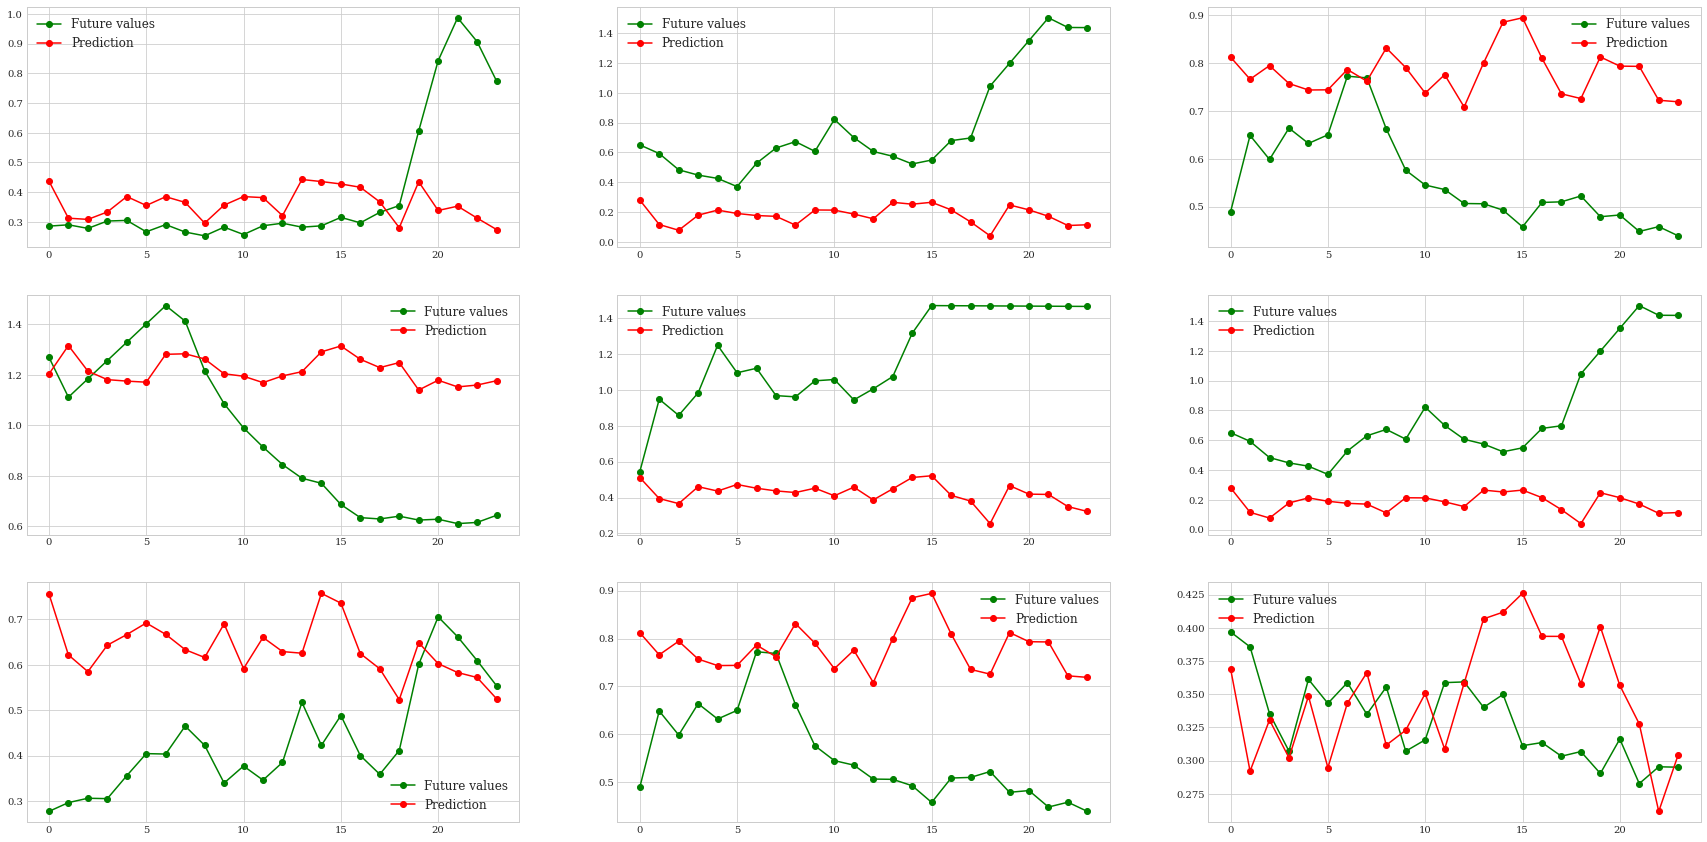

In [38]:
import matplotlib.pyplot as plt

subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 15) )
RandomInstances = [random.randint(1, REAL.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(range(Horizon), REAL[i],        color='g', marker = 'o')
    plt.plot(range(Horizon), PREDICTIONS[i], color='r', marker = 'o')

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()